In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from copy import deepcopy
import sys
from numpy import ceil
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR, CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir
from neuro.config import repo_dir, PROCESSED_DIR
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import sasc.viz
from PIL import Image
from sasc import config
from flatmaps_helper import VOX_COUNTS, load_known_rois, ROI_EXPLANATIONS_S03, FED_DRIVING_EXPLANATIONS_S03, FED_DRIVING_EXPLANATIONS_S02
from neuro.flatmaps_helper import load_flatmaps, load_custom_rois


# main load
normalize_flatmaps = False
# gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps(
    # normalize_flatmaps)
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03, gemv_flatmaps_dict_S02_timecourse, gemv_flatmaps_dict_S03_timecourse = load_flatmaps(
    normalize_flatmaps, load_timecourse=True)

### Select avg-response flatmaps

In [2]:
# select
avg_defaultdict = defaultdict(list)

for subject in ['S02', 'S03']:
    if subject == 'S03':
        gemv_flatmaps_dict = gemv_flatmaps_dict_S03
    elif subject == 'S02':
        gemv_flatmaps_dict = gemv_flatmaps_dict_S02
    common_keys = list(set(gemv_flatmaps_dict_S02.keys()).intersection(
        set(gemv_flatmaps_dict_S03.keys())))
    gemv_flatmaps_dict = {k: v for k,
                          v in gemv_flatmaps_dict.items() if k in common_keys}
    # gemv_flatmaps_dict = {k: v for k, v in gemv_flatmaps_dict.items(
    # ) if not k[0] in ROI_EXPLANATIONS_S03.values() and not k[0] in ['START', 'END']}

    ##################################################
    # rois_dict is a dictionary with keys as region names and np arrays of voxel masks as values

    # rois_dict_known = load_known_rois(subject)
    # rois_dict_comm = load_custom_rois(subject, suffix_setting='')
    rois_dict_fedorenko = load_custom_rois(
        subject, suffix_setting='_fedorenko')
    # rois_dict_spotlights = load_custom_rois(subject, suffix_setting='_spotlights')
    # | rois_dict_spotlights
    # rois_dict = rois_dict_comm | rois_dict_fedorenko  # | rois_dict_known
    # rois_dict = rois_dict_comm
    rois_dict = rois_dict_fedorenko

    ##################################################
    # compute means
    # avg_defaultdict = defaultdict(list)
    for roi_idx, roi in rois_dict.items():
        for explanation in gemv_flatmaps_dict.keys():
            avg_defaultdict[roi_idx + ' ' + subject].append(
                np.mean(gemv_flatmaps_dict[explanation][roi > 0]))
            # corrs_defaultdict[roi_idx].append(
            # np.corrcoef(roi, gemv_flatmaps_dict[explanation])[0, 1])

In [3]:
df = pd.DataFrame(avg_defaultdict, index=gemv_flatmaps_dict.keys())
# df = df.loc[common_keys]
df['AVG'] = df.mean(axis=1)

# remove 2nd val of index
df.index = [x[0] for x in df.index]

df = df.round(3).sort_values('AVG', ascending=False)
# display pandas formatting with redblue colormap centered at 0 rounded to 3 decimal places
vabs = max(abs(df.values.min()), abs(df.values.max()))
df.style.background_gradient(cmap='coolwarm', axis=None, vmax=vabs, vmin=-vabs).format("{:.3f}").set_caption(
    'Average GEM-V driving response averaged over ROI'
)

,Lang-0 S02,Lang-1 S02,Lang-2 S02,Lang-3 S02,Lang-4 S02,Lang-0 S03,Lang-1 S03,Lang-2 S03,Lang-3 S03,Lang-4 S03,AVG
Relationships,0.224,0.086,0.077,0.266,0.264,0.110,0.052,0.301,0.293,0.119,0.179
Introspection,-0.007,-0.016,-0.037,0.018,0.002,0.245,0.313,0.399,0.399,0.416,0.173
Dialogue,-0.161,-0.154,-0.213,-0.162,-0.180,0.184,0.522,0.475,0.637,0.614,0.156
Gruesome body imagery,-0.032,-0.012,-0.036,0.012,0.001,0.152,0.291,0.358,0.362,0.310,0.141
Location names,0.339,0.216,0.322,0.291,0.356,-0.026,-0.148,-0.026,-0.079,-0.014,0.123
Clothing and Physical Appearance,-0.011,-0.017,-0.069,-0.024,-0.088,0.046,0.009,0.429,0.408,0.241,0.092
Recognition,0.041,0.105,0.041,0.053,0.065,0.131,0.085,0.047,0.094,0.146,0.081
Years,-0.035,-0.082,-0.053,0.075,0.115,0.206,0.139,0.051,0.132,0.102,0.065
Professions and Personal Backgrounds,-0.137,-0.192,-0.165,-0.227,-0.160,0.251,0.206,0.332,0.241,0.245,0.039
Positive Emotional Reactions,-0.092,-0.080,-0.052,-0.121,-0.111,0.141,0.055,0.123,0.142,0.191,0.019


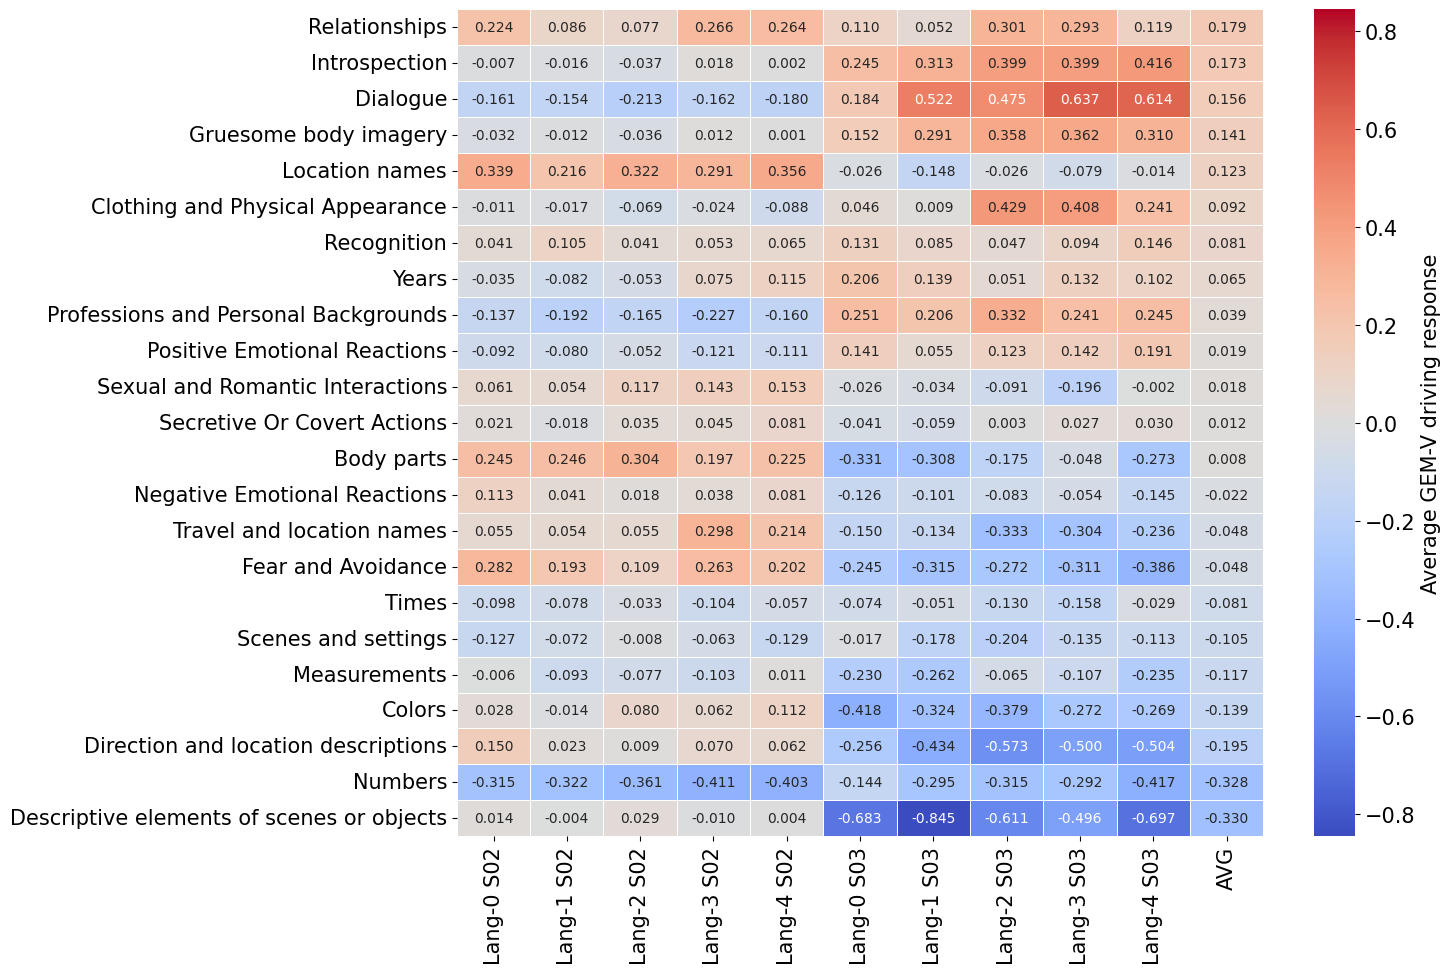

In [4]:
plt.figure(figsize=(15, 10))
# add label to cbar
sns.heatmap(df, annot=True, fmt='.3f', cmap='coolwarm', center=0, vmin=-vabs, vmax=vabs,
            annot_kws={"size": 10}, cbar_kws={"label": "Average GEM-V driving response"}, linewidths=.5)
plt.tight_layout()
plt.savefig('fed_drive_full.pdf')
plt.savefig('fed_drive_full.png', dpi=300, bbox_inches='tight')

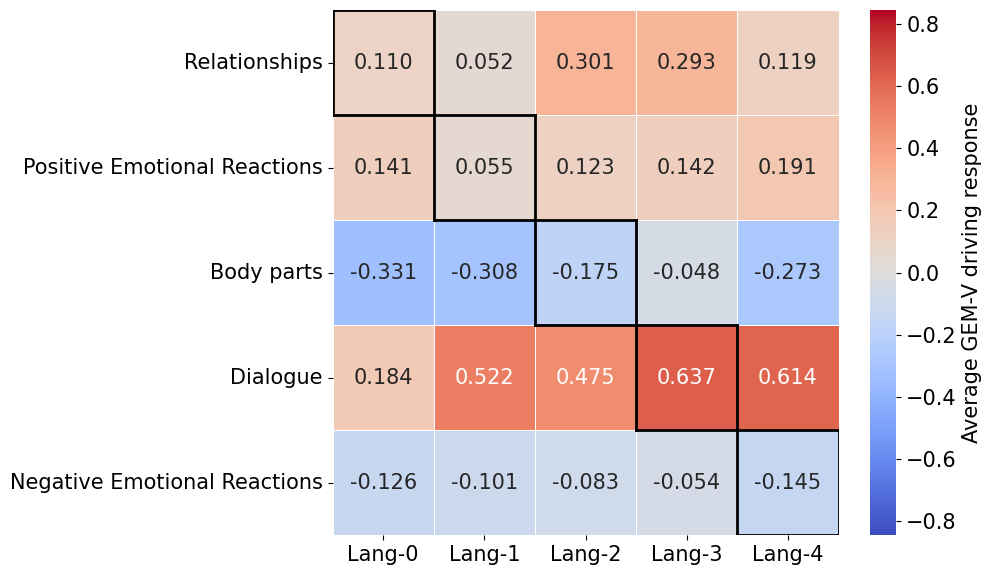

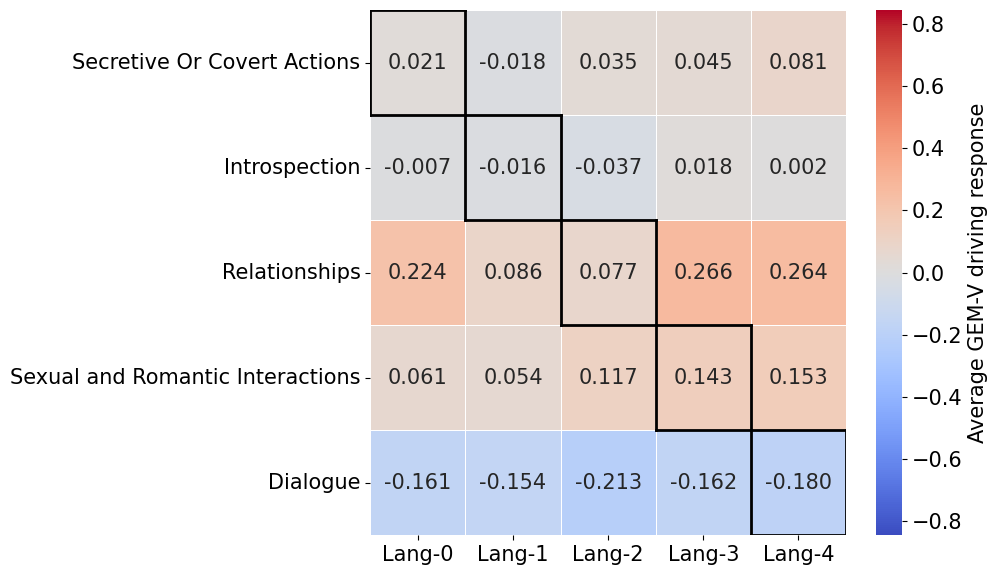

In [19]:
for subject in ['S03', 'S02']:
    if subject == 'S03':
        FED_DRIVING_EXPLANATIONS = FED_DRIVING_EXPLANATIONS_S03
    elif subject == 'S02':
        FED_DRIVING_EXPLANATIONS = FED_DRIVING_EXPLANATIONS_S02
    cols = [f'Lang-{i} {subject}' for i in range(5)]
    df_3 = df.loc[FED_DRIVING_EXPLANATIONS.values()][cols].rename(columns={
        k: k.replace(f' {subject}', '') for k in cols
    })
    plt.figure(figsize=(10, 6))
    # make fontsizes small
    sns.heatmap(df_3, annot=True, fmt='.3f', cmap='coolwarm', center=0, vmin=-vabs, vmax=vabs,
                cbar_kws={"label": "Average GEM-V driving response"}, linewidths=.5)
    dvu.outline_diagonal(df_3.values.shape, roffset=0.5,
                         coffset=0.5, color='black', lw=2)
    plt.tight_layout()
    plt.savefig(f'fed_drive_{subject}.pdf', bbox_inches='tight')

In [10]:
# sasc.viz._save_flatmap(
#     gemv_flatmaps_dict[('relationships between people', 'qa')], subject, fname_save=f'gemv_flatmaps/relationships_{subject}.png')

# Show flatmaps across subjects

In [ ]:
S02_flatmaps_dir = join(RESULTS_DIR, 'processed',
                        'flatmaps_all', 'UTS02', 'roi')
S03_flatmaps_dir = join(RESULTS_DIR, 'processed',
                        'flatmaps_all', 'UTS03', 'roi')

In [ ]:
# read a list of pngs and save them as a grid
for COMPARISONS in [
    ['Years', 'Time', 'Numbers', 'Measurements'],
    ['Relationships', 'Dialogue', 'Introspection'],
    ['Gruesome', 'Fear', 'Positive Emotional', 'Negative Emotional'],
    ['Clothing', 'Color'],
    ['Sexual', 'Secretive', 'Recognition', 'Professions']
]:

    pngs = defaultdict(list)
    for s in COMPARISONS:
        pngs['S02'] += [join(S02_flatmaps_dir, f)
                        for f in os.listdir(S02_flatmaps_dir) if f.endswith('.png') and s in f]
        pngs['S03'] += [join(S03_flatmaps_dir, f)
                        for f in os.listdir(S03_flatmaps_dir) if f.endswith('.png') and s in f]

    # plot as grid
    fig, axes = plt.subplots(
        2, len(COMPARISONS), figsize=(len(COMPARISONS) * 5, 6))
    for i, ax in enumerate(axes.flatten()):
        # ax.axis('off')
        # Remove all x-axis ticks and labels
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.label.set_visible(False)

        # Remove all y-axis ticks and labels (but keep the y-axis label)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])

        for spine in ax.spines.values():
            spine.set_visible(False)

    for i in range(len(COMPARISONS)):
        axes[0, i].imshow(plt.imread(pngs['S02'][i]))
        axes[0, i].set_title(COMPARISONS[i])
        axes[1, i].imshow(plt.imread(pngs['S03'][i]))
        axes[0, 0].set_ylabel('S02')
        axes[1, 0].set_ylabel('S03')

    # add
    plt.savefig('__'.join(COMPARISONS) + '.png', bbox_inches='tight', dpi=300)
    plt.show()